<a href="https://colab.research.google.com/github/AdsonRamos/if697-2020.2/blob/main/Projeto_IF697.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [107]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

# Carregando dados

In [108]:
#Carregando os datasets
customers = pd.read_csv("https://raw.githubusercontent.com/AdsonRamos/if697-2020.2/main/datasets/olist_customers_dataset.csv", encoding="ISO-8859-1")
geolocation = pd.read_csv("https://raw.githubusercontent.com/AdsonRamos/if697-2020.2/main/datasets/olist_geolocation_dataset.csv", encoding="ISO-8859-1")
order_items = pd.read_csv("https://raw.githubusercontent.com/AdsonRamos/if697-2020.2/main/datasets/olist_order_items_dataset.csv", encoding="ISO-8859-1")
order_payments = pd.read_csv("https://raw.githubusercontent.com/AdsonRamos/if697-2020.2/main/datasets/olist_order_payments_dataset.csv", encoding="ISO-8859-1")
order_reviews = pd.read_csv("https://raw.githubusercontent.com/AdsonRamos/if697-2020.2/main/datasets/olist_order_reviews_dataset.csv", encoding="ISO-8859-1")
orders = pd.read_csv("https://raw.githubusercontent.com/AdsonRamos/if697-2020.2/main/datasets/olist_orders_dataset.csv", encoding="ISO-8859-1")
products = pd.read_csv("https://raw.githubusercontent.com/AdsonRamos/if697-2020.2/main/datasets/olist_products_dataset.csv", encoding="ISO-8859-1")
sellers = pd.read_csv("https://raw.githubusercontent.com/AdsonRamos/if697-2020.2/main/datasets/olist_sellers_dataset.csv", encoding="ISO-8859-1")

In [109]:
#verificando valores nulos no dataset customers
customers.isnull().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [110]:
#verificando valores nulos no dataset geolocation
geolocation.isnull().sum()

geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

In [111]:
#verificando valores nulos no dataset order_items
order_items.isnull().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [112]:
#verificando valores nulos no dataset order_payments
order_payments.isnull().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

In [113]:
#verificando valores nulos no dataset order_reviews
order_reviews.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [114]:
#verificando valores nulos no dataset orders
orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [115]:
#verificando valores nulos no dataset products
products.isnull().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [116]:
#verificando valores nulos no dataset sellers
sellers.isnull().sum()

seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

#Estudo incial sobre o dataset de clientes

In [117]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [118]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [124]:
customers.describe()

,customer_zip_code_prefix
count,99441.000000
mean,35137.474583
std,29797.938996
min,1003.000000
25%,11347.000000
50%,24416.000000
75%,58900.000000
max,99990.000000


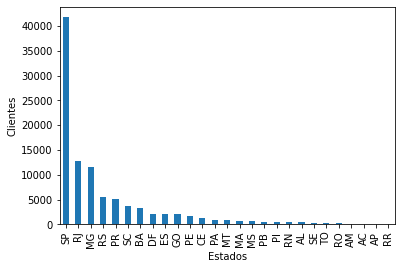

In [119]:
#Estados mais frequentes nos clients
customers['customer_state'].value_counts().plot(kind='bar', ylabel='Clientes', xlabel='Estados')

**Agrupamento por estados**

In [120]:
sudeste = ['MG', 'RJ', 'RS', 'SP']
nordeste = ['AL', 'BA', 'CE', 'MA', 'PB', 'PI', 'PE', 'RN', 'SE']
sul = ['PR', 'RS', 'SC']
norte = ['AM', 'RR', 'AP', 'PA', 'TO', 'RO', 'AC']
centro_oeste = ['MT', 'MS', 'GO']

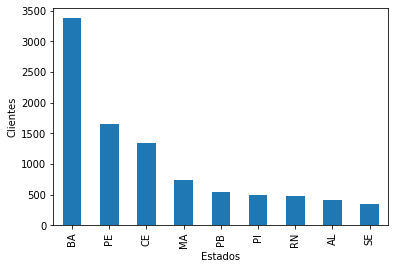

In [121]:
customers[customers.customer_state.isin(nordeste)]['customer_state'].value_counts().plot(kind='bar', ylabel='Clientes', xlabel='Estados')

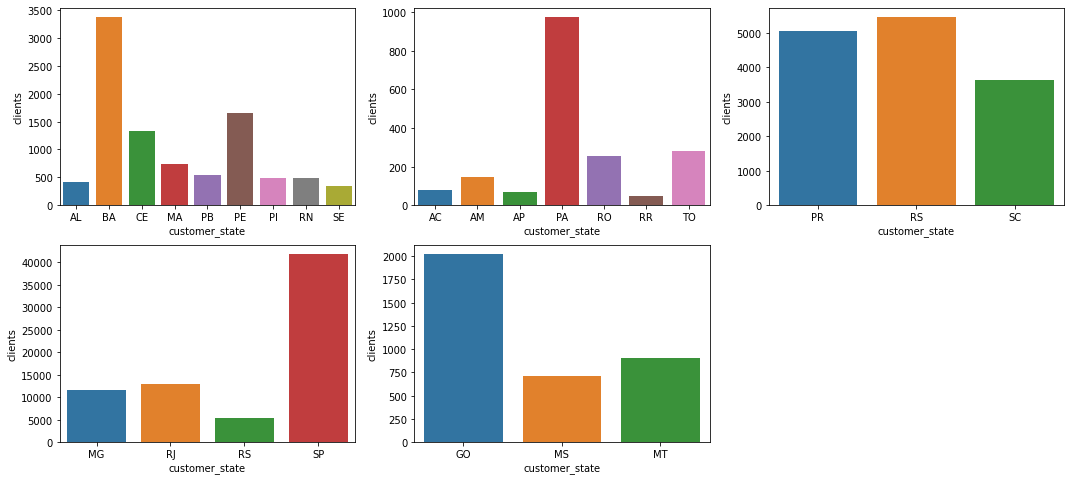

In [122]:
#Clientes distribuídos por regiões do país

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(18, 8))
fig.delaxes(axes[1,2])

northest_client_counts = customers[customers.customer_state.isin(nordeste)]['customer_state'].value_counts().rename_axis('customer_state').reset_index(name='clients')
northest_client_counts["customer_state"] = northest_client_counts["customer_state"].astype('category')

north_client_counts = customers[customers.customer_state.isin(norte)]['customer_state'].value_counts().rename_axis('customer_state').reset_index(name='clients')
north_client_counts["customer_state"] = north_client_counts["customer_state"].astype('category')

south_client_counts = customers[customers.customer_state.isin(sul)]['customer_state'].value_counts().rename_axis('customer_state').reset_index(name='clients')
south_client_counts["customer_state"] = south_client_counts["customer_state"].astype('category')

southest_client_counts = customers[customers.customer_state.isin(sudeste)]['customer_state'].value_counts().rename_axis('customer_state').reset_index(name='clients')
southest_client_counts["customer_state"] = southest_client_counts["customer_state"].astype('category')

midwest_client_counts = customers[customers.customer_state.isin(centro_oeste)]['customer_state'].value_counts().rename_axis('customer_state').reset_index(name='clients')
midwest_client_counts["customer_state"] = midwest_client_counts["customer_state"].astype('category')

#seaborn
sns.barplot(x='customer_state', y='clients', data=northest_client_counts, ax=axes[0][0])
sns.barplot(x='customer_state', y='clients', data=north_client_counts, ax=axes[0][1])
sns.barplot(x='customer_state', y='clients', data=south_client_counts, ax=axes[0][2])
sns.barplot(x='customer_state', y='clients', data=southest_client_counts, ax=axes[1][0])
sns.barplot(x='customer_state', y='clients', data=midwest_client_counts, ax=axes[1][1])